In [521]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [522]:
import numpy as np

In [523]:
from tidaldisruptionlrd import stellar_distribution, tde_rate
from tidaldisruptionlrd.constants import G

In [524]:
import importlib

importlib.reload(stellar_distribution)
importlib.reload(tde_rate)

<module 'tidaldisruptionlrd.tde_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tde_rate.py'>

In [525]:
profile = stellar_distribution.PlummerCuspProfile(
    # gamma=7/4,
    M_s=1e1,
    r_bin_min=1e-4,
    r_bin_max=1e6,
    N_bins=1000,
    reduce_factor=10,
    N_trapz_bins=100,
)

Calculating h(eps): 100%|██████████| 100/100 [00:03<00:00, 29.02it/s]


Reconstructing densities:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstructing densities: 100%|██████████| 1000/1000 [00:01<00:00, 900.60it/s]


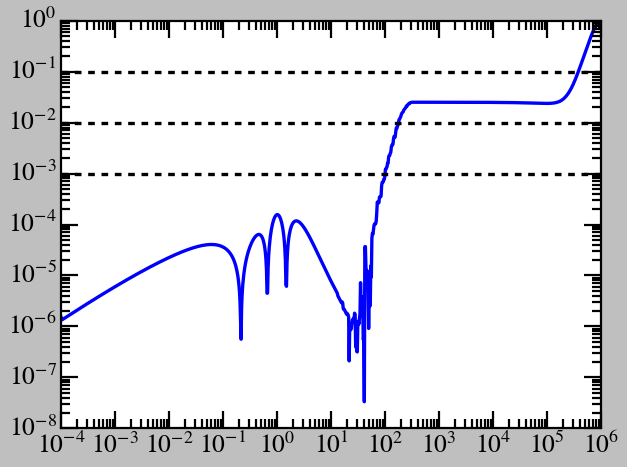

In [526]:
reconstructed_stellar_rho_bins = profile.reconstruct_stellar_rho_bins(
    -profile.phi_bins,
    profile.epsilon_bins,
    profile.g_epsilon_bins,
)

plt.plot(
    profile.r_bins,
    np.abs(1 - reconstructed_stellar_rho_bins / profile.stellar_rho_bins),
)

for tol in [1e-1, 1e-2, 1e-3]:
    plt.axhline(tol, color="k", ls="--")

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

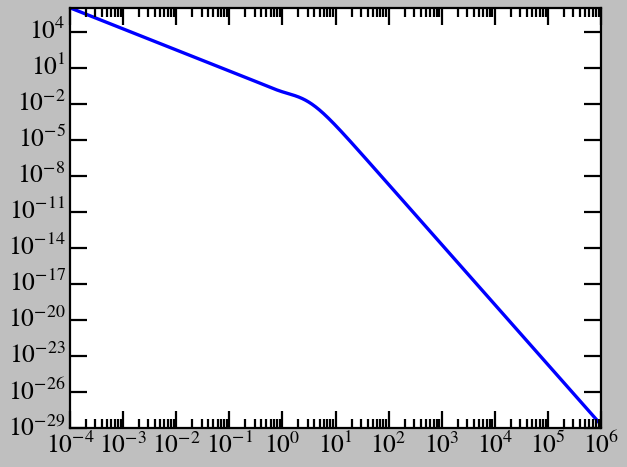

In [527]:
plt.plot(
    profile.r_bins,
    profile.stellar_rho_bins,
)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

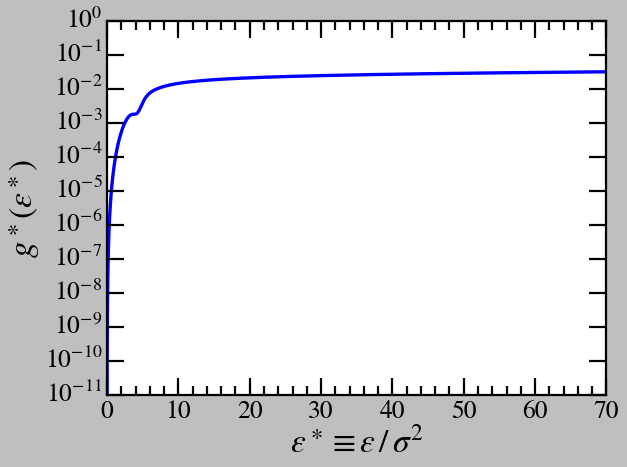

In [528]:
plt.plot(
    profile.epsilon_bins,
    profile.g_epsilon_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(0, 70)
plt.ylim(1e-11, 1e0)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$g^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

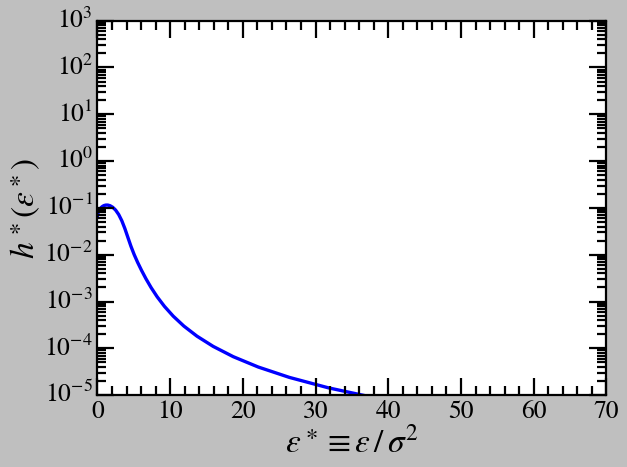

In [529]:
plt.plot(
    profile.reduced_epsilon_bins,
    profile.reduced_h_epsilon_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(0, 70)
plt.ylim(1e-5, 1e3)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$h^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

In [530]:
M_bh = np.logspace(6, 10, 100)
sigma = 200 * (M_bh / 10**8.32) ** (1 / 5.64)
# sigma = np.full_like(M_bh, 100)
a = 1 / 6 * G * M_bh * profile.M_s / sigma**2  # 0.2**2
r_h = a / profile.a
# r_h = G * M_bh / sigma**2
# r_h = G * M_bh / 2 / 100**2

tde = tde_rate.SalpeterTDERate(
    dimensionless_profile=profile,
    m_s_bins=np.linspace(0.08, 2, 1000),
    M_bhs=M_bh,
    r_hs=r_h,
)

# tde_const = tde_rate.SingleMassTDERate(
#     dimensionless_profile=profile,
#     m_s_bins=np.linspace(0.08, 2, 1000),
#     M_bhs=M_bh,
#     r_hs=r_h_const,
# )

Calculating TDE rates: 100%|██████████| 100/100 [00:01<00:00, 63.28it/s]


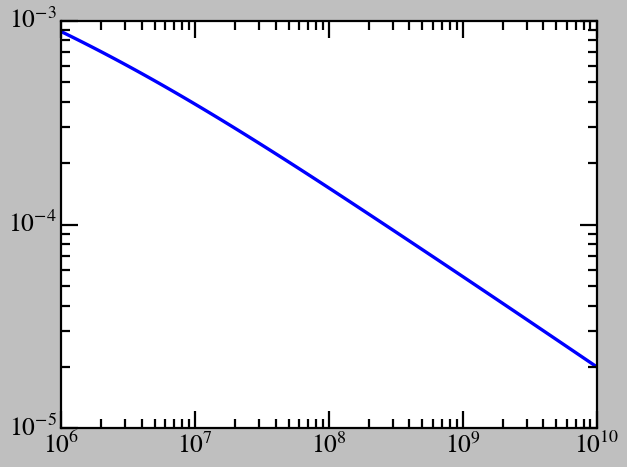

In [531]:
plt.plot(tde.M_bhs, tde.N_TDEs)
# plt.plot(tde_const.M_bhs, tde_const.N_TDEs)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e6, 1e10)
# plt.ylim(1e-5, 1e0)

plt.tight_layout()
plt.show()